# General API quickstart

In [53]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

In [54]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 1. Model creation
PyMC のモデルは ```Model``` クラスを中心にしています。 すべての確率変数 (RV) への参照があり、モデルの logp とその勾配を計算します。 通常は、 ```with``` コンテキストの一部としてインスタンス化します。

In [55]:
with pm.Model() as model:
    # Model definition
    pass

RV については以下でさらに説明しますが、`Model` クラスを探索するための簡単なモデルを作成してみましょう。

In [56]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu = 0, sigma = 1)
    obs = pm.Normal("obs", mu = mu, sigma = 1, observed = rng.standard_normal(100))

In [57]:
model.basic_RVs

[mu ~ Normal(0, 1), obs ~ Normal(mu, 1)]

In [58]:
model.free_RVs

[mu ~ Normal(0, 1)]

In [59]:
model.observed_RVs

[obs ~ Normal(mu, 1)]

In [60]:
model.compile_logp()({"mu": 0})

array(-143.03962875)

``logp`` を使用して行った設計上の選択を強調する価値があります。 上でわかるように、```logp``` は引数付きで呼び出されているため、モデルインスタンスのメソッドです。 より正確には、モデルの現在の状態に基づいて関数を組み立てます。 または、``logp`` への引数として指定された状態に基づいて指定します (以下の例を参照)。

さまざまな理由から、私たちは ```Model``` インスタンスが静的ではないと想定しています。 内部ループで ```logp``` を使用する必要があり、それが静的である必要がある場合は、単純に ```logp = model.logp``` のようなものを使用します。 以下に例を示します。キャッシュ効果と速度向上に注目してください。

In [61]:
%timeit model.compile_logp()({"mu": 0.1})
logp = model.compile_logp()
%timeit logp({"mu": 0.1})

78.9 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
16 µs ± 516 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## 2. Probability Distributions
すべての確率的プログラムは、観測されたランダム変数 (RV) と観測されていないランダム変数 (RV) で構成されます。 観測された RV は尤度分布によって定義され、観測されていない RV は事前分布によって定義されます。 PyMC モジュールでは、確率分布の構造は次のようになります。

[Distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions.html#api-distributions)

* [pymc:api_distributions_continuous](https://www.pymc.io/projects/docs/en/stable/api/distributions/continuous.html)
* [pymc:api_distributions_discrete](https://www.pymc.io/projects/docs/en/stable/api/distributions/discrete.html)
* [pymc:api_distributions_multivariate](https://www.pymc.io/projects/docs/en/stable/api/distributions/multivariate.html)
* [pymc:api_distributions_mixture](https://www.pymc.io/projects/docs/en/stable/api/distributions/mixture.html)
* [pymc:api_distributions_Timeseries](https://www.pymc.io/projects/docs/en/stable/api/distributions/timeseries.html)
* [pymc:api_distributions_censored](https://www.pymc.io/projects/docs/en/stable/api/distributions/censored.html)
* [pymc:api_distributions_simulator](https://www.pymc.io/projects/docs/en/stable/api/distributions/simulator.html)

### Unobserved Random Variables
監視されていないすべての RV には、名前 (文字列)、パラメータ キーワード引数の呼び出しシグネチャがあります。 したがって、通常の事前確率は次のようにモデル コンテキストで定義できます。

In [62]:
with pm.Model():
    x = pm.Normal("x", mu = 0, sigma = 1)

モデルと同様に、その ```logp``` を評価できます。

In [63]:
pm.logp(x, 0).eval()

array(-0.91893853)

### Observed Random Variables
観測された RV は観測されていない RV と同様に定義されますが、データを ```observed``` キーワード引数に渡す必要があります。

In [64]:
with pm.Model():
    obs = pm.Normal("x", mu = 0, sigma = 1, observed = rng.standard_normal(100))

``observed`` はリスト、``numpy.ndarray`` および ``pytensor`` データ構造をサポートします。

### Deterministic transforms
PyMC を使用すると、あらゆる種類の方法で RV を使用して代数を自由に実行できます。

In [65]:
with pm.Model():
    x = pm.Normal("x", mu = 0, sigma = 1)
    y = pm.Gamma("y", alpha=1, beta = 1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

これらの変換はシームレスに機能しますが、結果は自動的には保存されません。 したがって、変換された変数を追跡したい場合は、```pm.Deterministic``` を使用する必要があります。

In [66]:
with pm.Model():
    x = pm.Normal("x", mu = 0, sigma = 1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

```plus_2``` は上記と同じ方法で使用できることに注意してください。PyMC にこの RV を追跡するように指示するだけです。

### Lists of RVs / higher-dimensional RVs
上記では、スカラー RV を作成する方法を見てきました。 多くのモデルでは、複数の RV が必要です。 ユーザーは、次のように RV のリストを作成しようとすることがあります。

In [67]:
with pm.Model():
    # bad:
    x = [pm.Normal(f"x_{i}", mu = 0, sigma = 1) for i in range(10)]

これは機能しますが、速度が遅いためお勧めできません。 代わりに、[coordinates](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/Dimensionity.html#Dimensionity) を使用できます。

In [68]:
coords = {"cities": ["Santiago", "Mumbai", "Tokyo"]}
with pm.Model(coords=coords) as model:
    # good:
    x = pm.Normal("x", mu = 0, sigma = 1, dims = "cities")

```x``` は長さ 3 の配列になり、この配列内の 3 つの変数のそれぞれがラベルに関連付けられます。 これにより、結果を確認するときに 3 つの異なる変数を区別するのが非常に簡単になります。 この配列にインデックスを付けたり、線形代数演算を実行したりできます。

In [69]:
with model:
    y = x[0] * x[1]  # indexing is supported
    x.dot(x.T)  # linear algebra is supported

### Initialize Random Variables
PyMC はモデルを自動的に初期化しますが、RV の初期値を定義すると役立つ場合があります。 これは ```initval```` kwarg を介して実行できます。

In [70]:
with pm.Model(coords = {"idx": np.arange(5)}) as model:
    x = pm.Normal("x", mu = 0, sigma = 1, dims = "idx")

model.initial_point()

{'x': array([0., 0., 0., 0., 0.])}

In [71]:
with pm.Model(coords = {"idx": np.arange(5)}) as model:
    x = pm.Normal("x", mu = 0, sigma = 1, dims = "idx", initval = rng.standard_normal(5))

model.initial_point()

{'x': array([-0.36012097, -0.16168135,  1.07485641, -0.08855632, -0.03857412])}

この手法は、モデルの仕様または初期化に関する問題を特定するときに役立つことがあります。

## 3. Inference
モデルを定義したら、事後分布を近似する推論を実行する必要があります。 PyMC は、サンプリングと変分推論という 2 つの広範なクラスの推論をサポートします。

### 3.1 Sampling
MCMC サンプリング アルゴリズムへの主なエントリ ポイントは、```pm.sample()``` 関数経由です。 デフォルトでは、この関数は適切なサンプラーを自動割り当てしようとします。 ``pm.sample()```` は ```arviz.InferenceData```` オブジェクトを返します。 ```InferenceData``` オブジェクトはファイルから簡単に保存/ロードでき、日付/バージョンや事後予測サンプルなどの追加の (メタ) データを運ぶことができます。 詳細については、[ArviZ クイックスタート](https://python.arviz.org/en/latest/getting_started/Introduction.html#quickstart) をご覧ください。

In [72]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

    idata = pm.sample(2000)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


ご覧のとおり、連続変数のみを含むモデルでは、PyMC は NUTS サンプラーを割り当てます。これは、複雑なモデルであっても非常に効率的です。 PyMC は、サンプラーの適切な開始パラメーターを見つけるために初期チューニングも実行します。 ここでは、各チェーンの事後から 2000 個のサンプルを抽出し、サンプラーが追加の 1500 回の反復でパラメーターを調整できるようにします。

```chains```` kwarg を介して設定されていない場合、チェーンの数は利用可能な CPU コアの数から決定されます。

In [73]:
idata.posterior.dims

FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 2000})

チューニング サンプルはデフォルトでは破棄されます。 ```discard_tuned_samples = False``` を指定すると、それらは保持され、最終的に ```InferenceData``` オブジェクト内の別のグループ (つまり、```idata.warmup_posterior```) に配置されます。

``chains`` および ``cores`` kwargs を使用して、チェーンがどのように並列実行されるかを制御できます。

In [74]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu = 0, sigma = 1)
    obs = pm.Normal("obs", mu = mu, sigma = 1, observed=rng.standard_normal(100))

    idata = pm.sample(cores = 4, chains = 6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [mu]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 36 seconds.


In [75]:
idata.posterior["mu"].shape

(6, 1000)

In [76]:
# get values of a single chain
idata.posterior["mu"].sel(chain = 2).shape

(1000,)

### 3.2 Analyze sampling results
サンプリング結果を分析するために最も一般的に使用されるプロットは、いわゆるトレース プロットです。

In [77]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu = 0, sigma = 1)
    sd = pm.HalfNormal("sd", sigma = 1)
    obs = pm.Normal("obs", mu = mu, sigma = sd, observed = rng.standard_normal(100))

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sd'}>, <Axes: title={'center': 'sd'}>]],
      dtype=object)

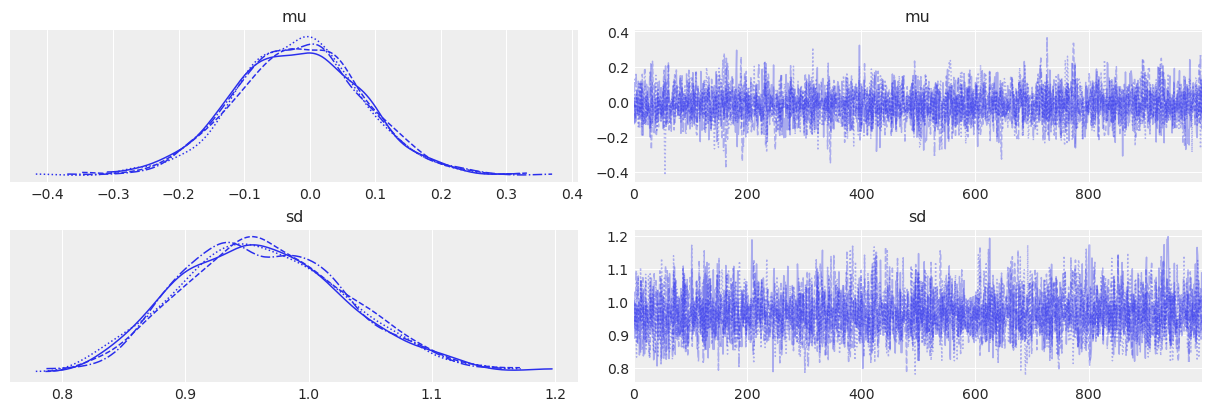

In [78]:
az.plot_trace(idata)

注目すべきもう 1 つの一般的な指標は、ゲルマン ルービン統計 (R ハット) です。

In [79]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.017,0.096,-0.192,0.167,0.002,0.002,3832.0,2339.0,1.0
sd,0.965,0.069,0.840,1.094,0.001,0.001,3794.0,2467.0,1.0


R-hat is also presented as part of the ```az.plot_forest```:

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

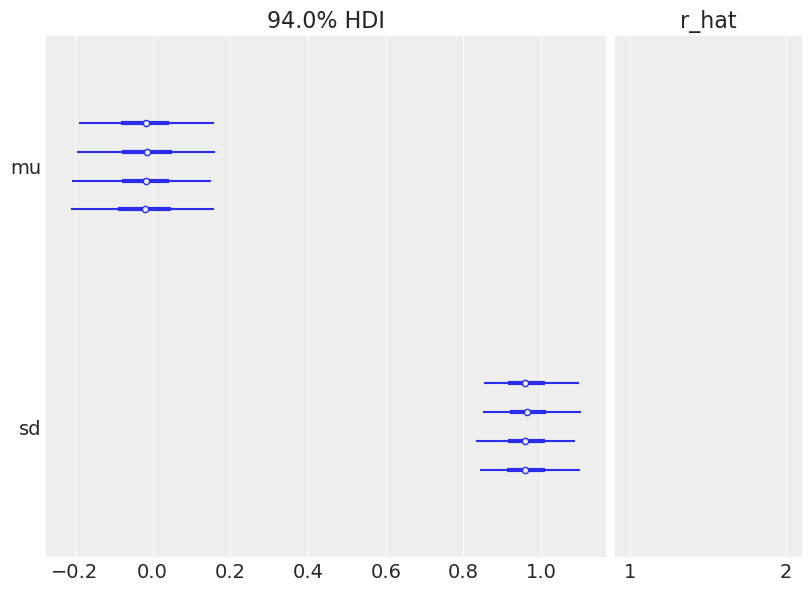

In [80]:
az.plot_forest(idata, r_hat = True)

最後に、[John Kruschke. Doing Bayesian data analysis: A tutorial with R, JAGS, and Stan. Academic Press, 2014.] からインスピレーションを得た事後分布のプロットには、次のものを使用できます。

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sd'}>],
      dtype=object)

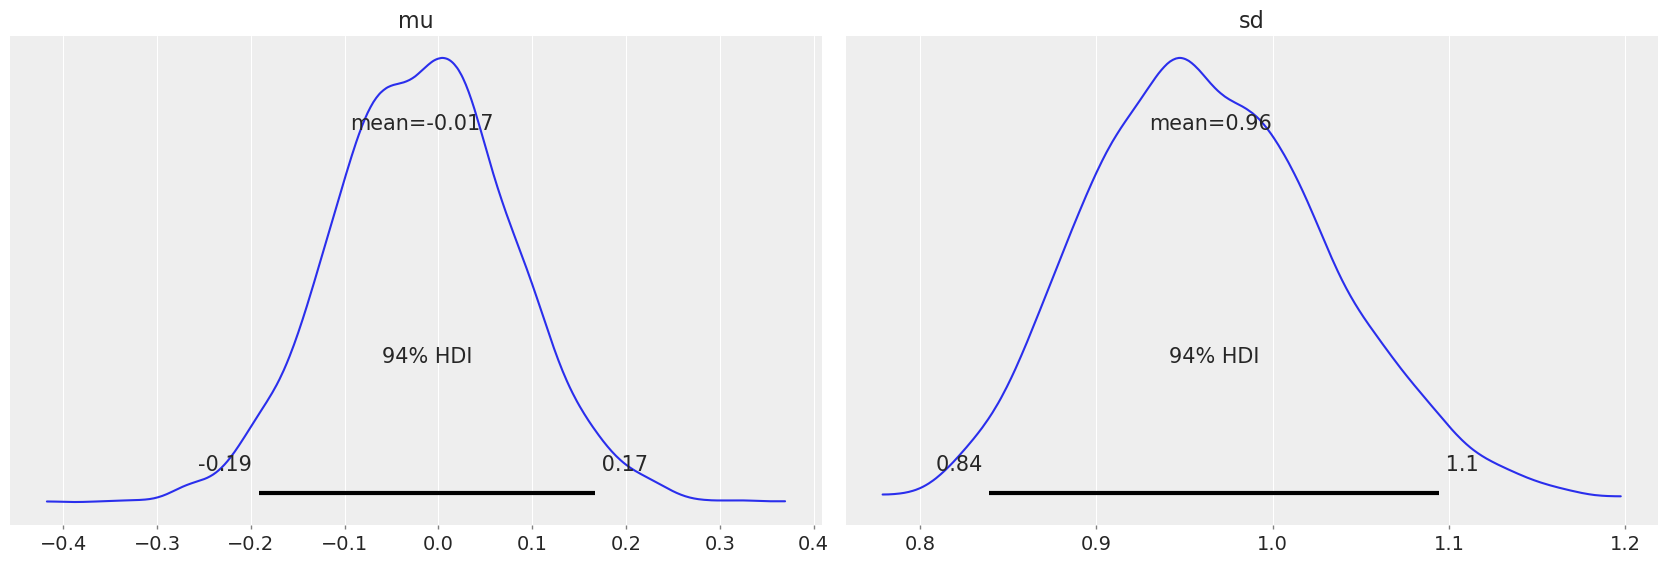

In [81]:
az.plot_posterior(idata)

高次元モデルの場合、すべてのパラメーターのトレースを確認するのは面倒になります。 ```NUTS``` を使用すると、エネルギー プロットを見て収束の問題を評価できます。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


<Axes: >

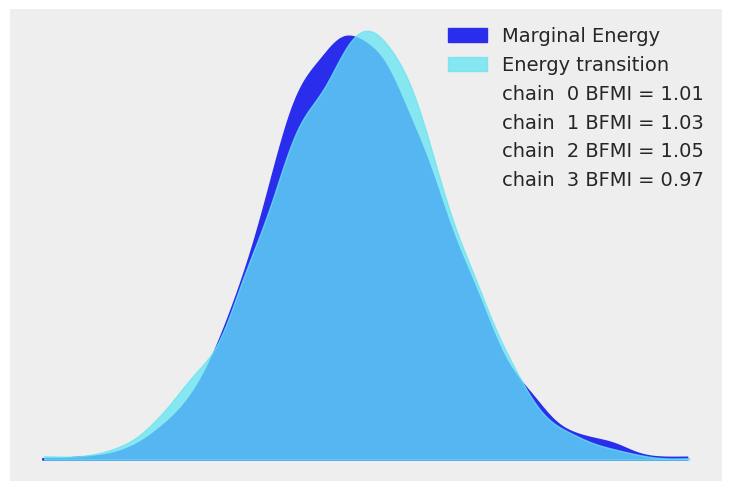

In [82]:
with pm.Model(coords={"idx": np.arange(100)}) as model:
    x = pm.Normal("x", mu=0, sigma=1, dims="idx")
    idata = pm.sample()

az.plot_energy(idata)

サンプラー統計とエネルギー プロットの詳細については、[サンプラー統計](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/sampler-stats.html#sampler-stats)を参照してください。 サンプリングの問題の特定とその対処方法の詳細については、[発散による偏った推論の診断](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html#diagnosing-with-divergences)を参照してください。

### 3.3 Variational inference
PyMC は、さまざまな変分推論手法をサポートしています。 これらの方法ははるかに高速ですが、多くの場合精度が低く、偏った推論につながる可能性があります。 メインのエントリ ポイントは ```pymc.fit()``` です。

In [83]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu = 0, sigma = 1)
    sd = pm.HalfNormal("sd", sigma = 1)
    obs = pm.Normal("obs", mu = mu, sigma = sd, observed = rng.standard_normal(100))

    approx = pm.fit()

Finished [100%]: Average Loss = 142.08


返された ````Approsimation```` オブジェクトには、近似事後分布からサンプルを描画するなど、さまざまな機能があり、通常のサンプリング実行と同じように分析できます。

In [84]:
idata = approx.sample(1000)
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.03,0.163,-0.321,0.281,0.005,0.004,875.0,944.0,NaN
sd,0.99,0.148,0.724,1.271,0.005,0.003,951.0,945.0,NaN


```variational``` サブモジュールは、使用する VI に大きな柔軟性を提供し、オブジェクト指向設計に従います。 たとえば、フルランク ADVI は完全な共分散行列を推定します。

In [85]:
mu = pm.floatX([0.0, 0.0])
cov = pm.floatX([[1, 0.5], [0.5, 1.0]])
with pm.Model(coords={"idx": np.arange(2)}) as model:
    pm.MvNormal("x", mu=mu, cov=cov, dims="idx")
    approx = pm.fit(method="fullrank_advi")

Finished [100%]: Average Loss = 0.025675


オブジェクト指向インターフェイスを使用した同等の式は次のとおりです。

In [86]:
with pm.Model(coords = {"idx": np.arange(2)}) as model:
    pm.MvNormal("x", mu = mu, cov = cov, dims = "idx")
    approx = pm.FullRankADVI().fit()

Finished [100%]: Average Loss = 0.019521


In [87]:
with pm.Model(coords = {"idx": np.arange(2)}) as model:
    pm.MvNormal("x", mu = mu, cov = cov, dims = "idx")
    approx = pm.FullRankADVI().fit()

Finished [100%]: Average Loss = 0.02667


<Axes: xlabel='x\n0', ylabel='x\n1'>

<Figure size 720x480 with 0 Axes>

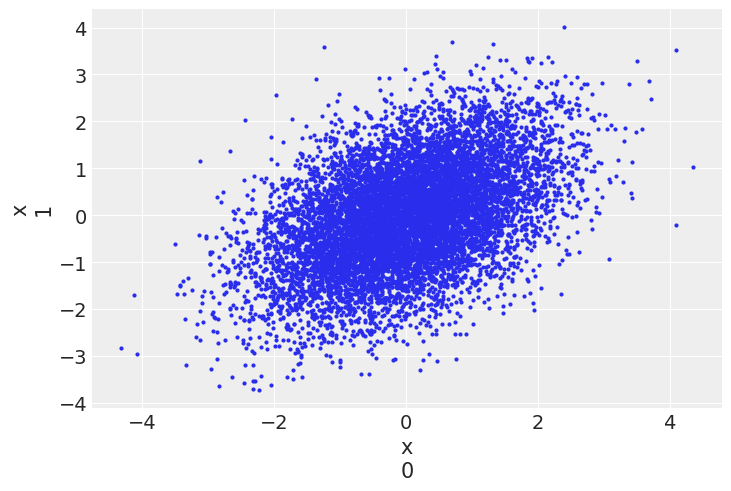

In [88]:
plt.figure()
idata = approx.sample(10000)
az.plot_pair(idata, var_names = "x", coords = {"idx": [0, 1]})

Stein 変分勾配降下法 (SVGD) は粒子を使用して事後分布を推定します。

In [89]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])
with pm.Model() as model:
    pm.NormalMixture("x", w = w, mu = mu, sigma = sd)
    approx = pm.fit(method = pm.SVGD(n_particles = 200, jitter = 1.0))

In [90]:
with pm.Model() as model:
    pm.NormalMixture("x", w=[0.2, 0.8], mu=[-0.3, 0.5], sigma=[0.1, 0.1])

<Axes: >

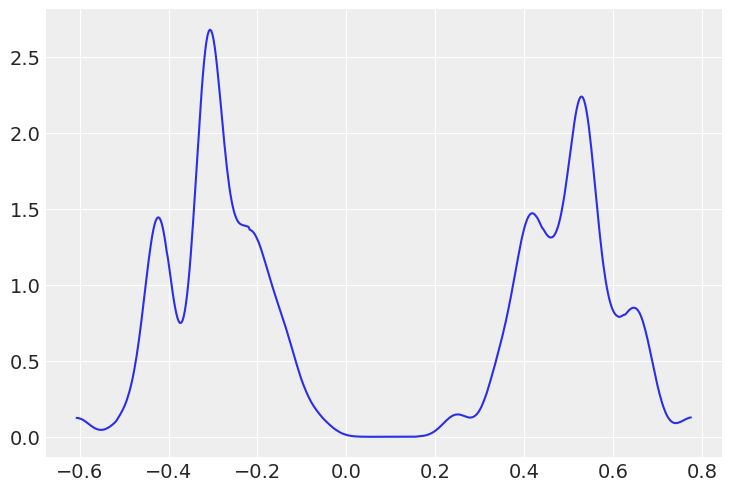

In [91]:
plt.figure()
idata = approx.sample(10000)
az.plot_dist(idata.posterior["x"])

変分推論の詳細については、[変分推論](https://www.pymc.io/projects/examples/en/latest/gallery.html#variational-inference)を参照してください。

## 4. Posterior Predictive Sampling
```sample_posterior_predictive()``` 関数は、ホールドアウト データの予測と事後予測チェックを実行します。

In [92]:
data = rng.standard_normal(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu = 0, sigma = 1)
    sd = pm.HalfNormal("sd", sigma = 1)
    obs = pm.Normal("obs", mu = mu, sigma = sd, observed = data)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [93]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


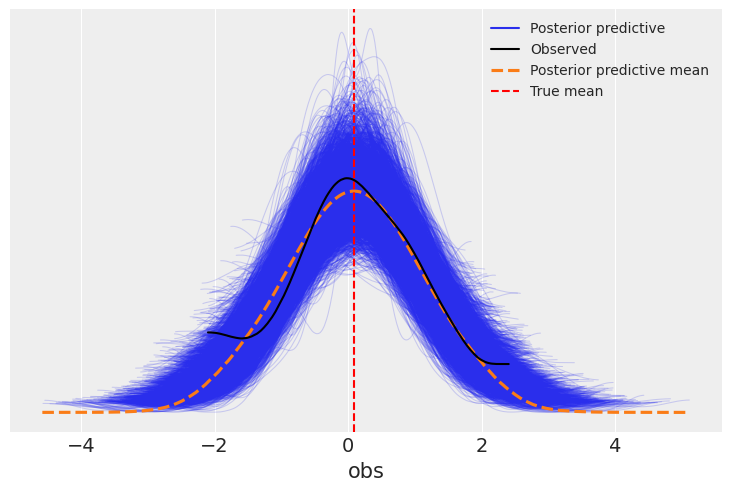

In [94]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax = ax)
ax.axvline(data.mean(), ls = "--", color = "r", label = "True mean")
ax.legend(fontsize = 10)

### 4.1 Predicting on hold-out data
多くの場合、目に見えないデータやホールドアウトされたデータに基づいて予測する必要があります。 これは、確率的機械学習とベイジアン深層学習に特に関係します。 PyMC には、そのような用途に役立つ ```pm.MutableData``` コンテナが含まれています。 これは ``pytensor.shared`` 変数のラッパーであり、データの値を後で変更できるようにします。 それ以外の場合は、 ```pm.MutableData``` オブジェクトを他の numpy 配列またはテンソルと同様に使用できます。

PyMC のすべてのモデルは内部的に巨大なシンボリック式であるため、この違いは重要です。 生データをモデルに直接渡すと、このデータを定数として扱い、それが合理的であれば最適化する許可を PyTensor に与えることになります。 後でこのデータを変更する必要がある場合、より大きなシンボリック式内でそのデータを指定する方法がない可能性があります。 ``pm.MutableData```` を使用すると、シンボリック式内の特定の場所をポイントし、そこにあるものを変更する方法が提供されます。

In [95]:
x = rng.standard_normal(100)
y = x > 0

coords = {"idx": np.arange(100)}
with pm.Model() as model:
    # create shared variables that can be changed later on
    x_obs = pm.MutableData("x_obs", x, dims = "idx")
    y_obs = pm.MutableData("y_obs", y, dims = "idx")

    coeff = pm.Normal("x", mu = 0, sigma = 1)
    logistic = pm.math.sigmoid(coeff * x_obs)
    pm.Bernoulli("obs", p = logistic, observed = y_obs, dims = "idx")
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


ここで、目に見えないデータを予測したいと仮定します。 このためには、```x_obs``` と ```y_obs``` の値を変更する必要があります。 理論的には、予測したいので ```y_obs``` を設定する必要はありませんが、```x_obs``` の形状と一致する必要があります。

In [98]:
with model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            # use dummy values with the same shape:
            "y_obs": [0, 0, 0],
        },
        coords = {"idx": [1001, 1002, 1003]},
    )

    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


## References
1. John Kruschke. Doing Bayesian data analysis: A tutorial with R, JAGS, and Stan. Academic Press, 2014.

In [97]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Apr 02 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.19.0
aeppl   : not installed
xarray  : 2024.3.0

matplotlib: 3.8.3
arviz     : 0.17.1
numpy     : 1.26.4
pymc      : 5.12.0
pytensor  : 2.19.0

Watermark: 2.4.3



## License notice
All the notebooks in this example gallery are provided under the MIT License which allows modification, and redistribution for any use provided the copyright and license notices are preserved.

## Citing PyMC examples
このノートブックを引用するには、Zenodo が提供する pymc-examples リポジトリの DOI を使用してください。

````
```
多くのノートブックは他の情報源 (ブログ、書籍など) から改変されています。そのような場合は、元の情報源も引用する必要があります。

また、コードで使用される関連ライブラリを忘れずに引用してください。
```
````

```py
@incollection{citekey,
  author    = "<notebook authors, see above>",
  title     = "<notebook title>",
  editor    = "PyMC Team",
  booktitle = "PyMC examples",
  doi       = "10.5281/zenodo.5654871"
}
```

レンダリングすると次のようになります。

Christian Luhmann . "General API quickstart". In: PyMC Examples. Ed. by PyMC Team. DOI: 10.5281/zenodo.5654871